In [76]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

# def dist2LMC(ra, dec):
#     ra1 = np.copy(ra)
#     dec1 = np.copy(dec)
#     ra1 *= np.pi/180
#     dec1 *= np.pi/180
#     alph0 = 81.9*np.pi/180 #ra of LMC center
#     delt0 = -69.866667*np.pi/180 #dec of LMC center
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
#     d0 = 49.9
#     iota = 27.81*np.pi/180 #inclination
#     pa = 146.37*np.pi/180  #position angle of line-of-nodes
#     rho = np.arccos(cd*np.cos(dec1)*np.cos(ra1 - alph0) + sd*np.sin(dec1))
#     phi = np.arccos(-np.cos(dec1)*np.sin(ra1 - alph0)*(1/np.sin(rho)))
#     dis = d0*(np.cos(iota)/(np.cos(iota)*np.cos(rho)-np.sin(iota)*np.sin(rho)*np.sin(phi - pa)))
#     rho *= (180/np.pi)
#     phi *= (180/np.pi)    
#     return rho, phi, dis

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [77]:
###################
### Import Data ###
###################

filepath1 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' 
filepath2 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/output_LMC_DR16_all.fits' 

pdfout = fits.getdata(filepath1, 1)
original = fits.getdata(filepath2, 1)

tpdfout = Table(pdfout)
torigin = Table(original)

print(tpdfout.columns)
print(' ')
print(toriginal.columns)

<TableColumns names=('OBJ','AGE','MASS','LOGG','P','P2','P3','P4','P_MEAN','P2_MEAN','P3_MEAN','P4_MEAN','P_VAR','P2_VAR','P3_VAR','P4_VAR','PMASS','PLOGG')>
 
<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX

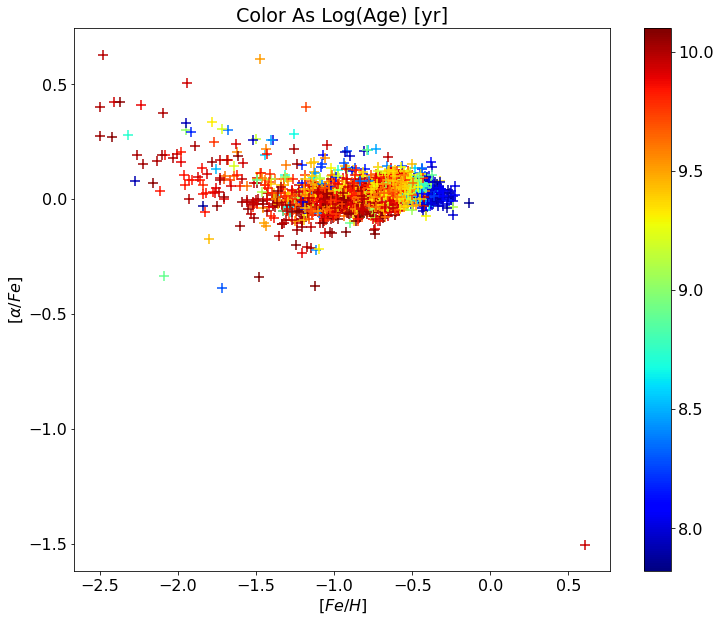

In [78]:
cln = np.where((torigin['FE_H']!=-9999)&(tpdfout['P_MEAN']>-90))

plt.figure(figsize=[12,10])
plt.scatter(torigin['FE_H'][cln],\
            np.subtract(np.add(torigin['ALPHA_M'][cln],torigin['M_H'][cln]),torigin['FE_H'][cln]),\
           c=tpdfout['P_MEAN'][cln],marker='+',s=100,cmap='jet')
plt.colorbar()
plt.xlabel(r'$[Fe/H]$')
plt.ylabel(r'$[\alpha/Fe]$')
plt.title(r'Color As Log(Age) [yr]')
plt.show()

In [79]:
###############################
### Import LinearRegression ###
###############################

from sklearn import linear_model as lm 
import statsmodels.api as sm 

####################
### Prepare Data ###
####################

'''parameters: logTe, Hmag, [FE/H], logg'''\

logage = np.array(tpdfout[cln]['P_MEAN'].data)

J = np.array(toriginal[cln]['J'])
Ks = np.array(toriginal[cln]['K'])

logteff = np.array(np.log10(toriginal[cln]['TEFF']).data)
H = np.array(toriginal[cln]['H'].data)
feh = np.array(toriginal[cln]['FE_H'])
logg = np.array(toriginal[cln]['LOGG'])

In [80]:
#Everything
lin = np.array([logteff,H,feh,logg]).T
lin = sm.add_constant(lin)
  
model = sm.OLS(logage, lin).fit()
predictions = model.predict(lin) 

print_model = model.summary()
print(r'logteff,H,feh,logg:')
print(print_model)
print(' ')

#Carrera Like 
car = np.array([J-Ks,H,feh,(J-Ks)**2,feh**2,(J-Ks)**3]).T
car = sm.add_constant(car)
  
model = sm.OLS(logage, car).fit()
predictionsquaJKs = model.predict(car) 

print_model = model.summary()
print(r'J-Ks,H,feh,(J-Ks)**2,feh**2,(J-Ks)**3:')
print(print_model)
print(' ')

#Carrera Like with logg
car = np.array([J-Ks,H,feh,(J-Ks)**2,feh**2,(J-Ks)**3,logg]).T
car = sm.add_constant(car)
  
model = sm.OLS(logage, car).fit()
predictionsqualogg = model.predict(car) 

print_model = model.summary()
print(r'J-Ks,H,feh,(J-Ks)**2,feh**2,(J-Ks)**3,logg:')
print(print_model)
print(' ')

#Carrera Like with logg no feh
car = np.array([J-Ks,H,(J-Ks)**2,(J-Ks)**3,logg]).T
car = sm.add_constant(car)
  
model = sm.OLS(logage, car).fit()
predictionsqualogg = model.predict(car) 

print_model = model.summary()
print(r'J-Ks,H,(J-Ks)**2,(J-Ks)**3,logg:')
print(print_model)
print(' ')

logteff,H,feh,logg:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     3920.
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        13:42:18   Log-Likelihood:                 233.05
No. Observations:                2736   AIC:                            -456.1
Df Residuals:                    2731   BIC:                            -426.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.9872      1.328